In [2]:
%matplotlib inline


# Tutorial for time series

In this tutorial we describe how to use
:class:`~mapie.time_series_regression.MapieTimeSeriesRegressor`
to estimate prediction intervals associated with time series forecast.

Here, we use the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.

Before estimating prediction intervals with MAPIE, we optimize the base model,
here a Random Forest model. The hyper-parameters are
optimized with a :class:`~sklearn.model_selection.RandomizedSearchCV` using a
sequential :class:`~sklearn.model_selection.TimeSeriesSplit` cross validation,
in which the training set is prior to the validation set.

Once the base model is optimized, we can use
:class:`~MapieTimeSeriesRegressor` to estimate
the prediction intervals associated with one-step ahead forecasts through
the EnbPI method [1].

As its parent class :class:`~MapieRegressor`,
:class:`~MapieTimeSeriesRegressor` has two main arguments : "cv", and "method".
In order to implement EnbPI, "method" must be set to "enbpi" (the default
value) while "cv" must be set to the :class:`~mapie.subsample.BlockBootstrap`
class that block bootstraps the training set.
This sampling method is used in [1] instead of the traditional bootstrap
strategy as it is more suited for time series data.

The EnbPI method allows you update the residuals during the prediction,
each time new observations are available so that the deterioration of
predictions, or the increase of noise level, can be dynamically taken into
account. It can be done with :class:`~MapieTimeSeriesRegressor` through
the ``partial_fit`` class method called at every step.

[1] Chen Xu and Yao Xie.
“Conformal Prediction Interval for Dynamic Time-Series.”
International Conference on Machine Learning (ICML, 2021).


In [1]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor

warnings.simplefilter("ignore")

import sys
sys.path.append("../code_preparation/")
from src.utils import read_split_csv, read_complete

## 1. Load input data and dataset preparation


## Toy data
The Victoria electricity demand dataset can be downloaded directly on the
MAPIE github repository. It consists in hourly electricity demand (in GW)
of the Victoria state in Australia together with the temperature
(in Celsius degrees). We extract temporal features out of the date and hour.



In [5]:
num_test_steps = 24 * 7

url_file = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/"
    "examples/data/demand_temperature.csv"
)
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)
demand_df["Date"] = pd.to_datetime(demand_df.index)
# demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
# demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)

In [15]:
demand_df

,Demand,Temperature,Date,Hour,Lag_1,Lag_2,Lag_3,Lag_4
2014-01-01 00:00:00,3.794,18.05,2014-01-01 00:00:00,0,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,3.418,17.20,2014-01-01 01:00:00,1,3.794,NaN,NaN,NaN
2014-01-01 02:00:00,3.152,16.45,2014-01-01 02:00:00,2,3.418,3.794,NaN,NaN
2014-01-01 03:00:00,3.026,16.65,2014-01-01 03:00:00,3,3.152,3.418,3.794,NaN
2014-01-01 04:00:00,3.022,16.40,2014-01-01 04:00:00,4,3.026,3.152,3.418,3.794
...,...,...,...,...,...,...,...,...
2014-02-25 19:00:00,2.968,20.10,2014-02-25 19:00:00,19,5.066,5.455,5.957,6.226
2014-02-25 20:00:00,2.742,19.90,2014-02-25 20:00:00,20,4.968,5.066,5.455,5.957
2014-02-25 21:00:00,2.304,19.30,2014-02-25 21:00:00,21,4.742,4.968,5.066,5.455
2014-02-25 22:00:00,2.105,19.05,2014-02-25 22:00:00,22,4.304,4.742,4.968,5.066


We now introduce a brutal changepoint in the test set by decreasing the
electricity demand by 2 GW on February 22.
It aims at simulating an effect, such as blackout or lockdown due to a
pandemic, that was not taken into account by the model during its training.



In [6]:
demand_df.Demand.iloc[-int(num_test_steps/2):] -= 2

The last week of the dataset is considered as test set, the remaining data
is used as training set.



In [7]:
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Hour", "Temperature"]
features += [f"Lag_{hour}" for hour in range(1, n_lags)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, "Demand"]
X_test = demand_test.loc[:, features]
y_test = demand_test["Demand"]

In [16]:
X_test

,Hour,Temperature,Lag_1,Lag_2,Lag_3,Lag_4
2014-02-19 00:00:00,0,19.15,4.431,4.184,4.462,5.003
2014-02-19 01:00:00,1,18.80,3.969,4.431,4.184,4.462
2014-02-19 02:00:00,2,18.55,3.660,3.969,4.431,4.184
2014-02-19 03:00:00,3,18.20,3.480,3.660,3.969,4.431
2014-02-19 04:00:00,4,17.75,3.470,3.480,3.660,3.969
...,...,...,...,...,...,...
2014-02-25 19:00:00,19,20.10,5.066,5.455,5.957,6.226
2014-02-25 20:00:00,20,19.90,4.968,5.066,5.455,5.957
2014-02-25 21:00:00,21,19.30,4.742,4.968,5.066,5.455
2014-02-25 22:00:00,22,19.05,4.304,4.742,4.968,5.066


Let's now visualize the training and test sets with the changepoint.



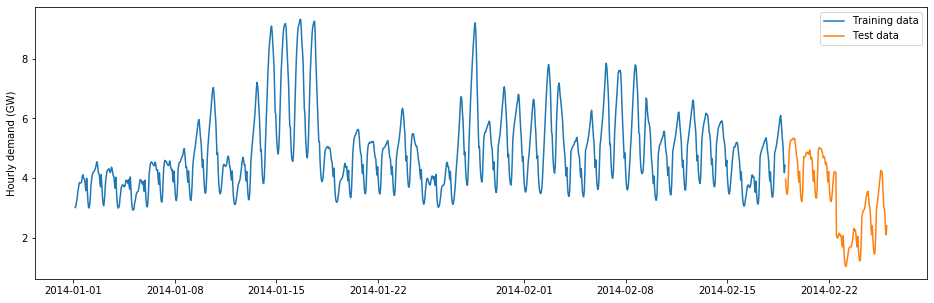

In [8]:
plt.figure(figsize=(16, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.ylabel("Hourly demand (GW)")
plt.legend(["Training data", "Test data"])
plt.show()

## Drone data

In [2]:
demand_df = read_complete("/App/Data/split_quad/") 

cols_ignored = ["time_start","battery_voltage","battery_current", "altitude","speed","route", "position_x", "position_y", "flight"]
cols_redundent = ["linear_acceleration_x", "velocity_y", "power"]
target = ["power_smoothed"]

def split(df, target=target, to_drop=cols_ignored+cols_redundent):
    y = df[target]
    X = df.drop(columns=to_drop+target)
    return X, y

# sur un seul vol
X, y = split(demand_df.loc[demand_df.flight==160], to_drop=cols_ignored+cols_redundent+["payload"]) # retire la payload aussi comme on a un seul vol
X

val.csv
train.csv
test.csv
lourd.csv


,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z
index,,,,,,,,,,,,,,,
121529,0.00,1.0,45.0,275.819616,0.005125,0.010743,-0.705665,0.708446,-0.003931,0.002027,-0.005896,-0.003686,-0.009418,-0.229584,-9.808363
121530,0.20,1.0,44.0,275.803999,0.005141,0.010757,-0.705679,0.708431,0.003488,0.000746,0.002762,0.001456,-0.002550,-0.218533,-9.804754
121531,0.30,1.0,43.0,275.788884,0.005221,0.010900,-0.705699,0.708408,-0.000071,0.003596,-0.013148,-0.008195,-0.014567,-0.220173,-9.804471
121532,0.50,1.0,40.0,275.789202,0.005213,0.010922,-0.705663,0.708445,-0.003286,0.003791,-0.036802,-0.026617,-0.001591,-0.196277,-9.798787
121533,0.61,1.0,40.0,275.772139,0.005281,0.010868,-0.705691,0.708417,0.005123,0.002055,0.004020,0.029511,0.008821,-0.246620,-9.805998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122724,179.40,1.9,140.0,271.134392,0.023352,0.017598,-0.685528,0.727458,-0.001232,-0.215426,0.022572,0.014284,-0.039601,-0.588015,-9.798218
122725,179.51,1.9,139.0,271.112920,0.023199,0.017440,-0.685545,0.727451,-0.007442,-0.214115,-0.028476,-0.018052,0.031644,-0.550212,-9.774520
122726,179.60,1.8,141.0,271.128570,0.022990,0.017094,-0.685580,0.727434,0.000727,-0.185655,0.028719,-0.006566,-0.051849,-0.472992,-9.776629


In [6]:
len(demand_df.flight.unique())

196

The last week of the dataset is considered as test set, the remaining data
is used as training set.



In [13]:
num_test_steps = 250

X_train, y_train = X.iloc[:-num_test_steps,:], y.iloc[:-num_test_steps]
X_test, y_test = X.iloc[-num_test_steps:,:], y.iloc[-num_test_steps:]

X_train

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z
index,,,,,,,,,,,,,,,
121529,0.00,1.0,45.0,275.819616,0.005125,0.010743,-0.705665,0.708446,-0.003931,0.002027,-0.005896,-0.003686,-0.009418,-0.229584,-9.808363
121530,0.20,1.0,44.0,275.803999,0.005141,0.010757,-0.705679,0.708431,0.003488,0.000746,0.002762,0.001456,-0.002550,-0.218533,-9.804754
121531,0.30,1.0,43.0,275.788884,0.005221,0.010900,-0.705699,0.708408,-0.000071,0.003596,-0.013148,-0.008195,-0.014567,-0.220173,-9.804471
121532,0.50,1.0,40.0,275.789202,0.005213,0.010922,-0.705663,0.708445,-0.003286,0.003791,-0.036802,-0.026617,-0.001591,-0.196277,-9.798787
121533,0.61,1.0,40.0,275.772139,0.005281,0.010868,-0.705691,0.708417,0.005123,0.002055,0.004020,0.029511,0.008821,-0.246620,-9.805998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122474,141.90,6.2,9.0,318.641513,-0.035767,-0.004498,0.117363,0.992435,-0.222425,0.362372,-0.073610,0.011205,-0.206989,0.152057,-10.007160
122475,142.01,6.2,10.0,318.654200,-0.038377,-0.006210,0.115469,0.992550,-0.204600,0.371081,-0.066698,-0.152143,0.165090,-0.057472,-10.036418
122476,142.20,6.2,9.0,318.644004,-0.043993,-0.006396,0.113650,0.992526,-0.199664,0.348186,-0.035257,-0.115364,0.067144,0.061256,-9.537189


In [14]:
X_test

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z
index,,,,,,,,,,,,,,,
122479,142.61,6.1,7.0,318.651534,-0.035125,-0.012470,0.112036,0.993005,-0.186255,0.399737,0.018815,0.119004,-0.006290,-0.018519,-10.031331
122480,142.70,6.0,6.0,318.659365,-0.026512,-0.015980,0.116885,0.992663,-0.176690,0.331119,-0.131646,0.249156,-0.059342,0.417351,-9.636752
122481,142.91,5.9,6.0,318.661891,0.043059,-0.009871,0.122736,0.991456,-0.146366,-0.001029,-0.138502,0.721910,-0.101999,0.201899,-9.627622
122482,143.00,5.9,8.0,318.658839,0.079448,-0.006114,0.124441,0.989022,-0.112606,-0.361031,0.076678,0.728618,-0.006780,0.129690,-9.406469
122483,143.21,5.8,18.0,318.657138,0.107515,-0.003272,0.125323,0.986268,-0.109188,-0.629560,0.000771,0.540317,-0.026142,0.206470,-9.451895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122724,179.40,1.9,140.0,271.134392,0.023352,0.017598,-0.685528,0.727458,-0.001232,-0.215426,0.022572,0.014284,-0.039601,-0.588015,-9.798218
122725,179.51,1.9,139.0,271.112920,0.023199,0.017440,-0.685545,0.727451,-0.007442,-0.214115,-0.028476,-0.018052,0.031644,-0.550212,-9.774520
122726,179.60,1.8,141.0,271.128570,0.022990,0.017094,-0.685580,0.727434,0.000727,-0.185655,0.028719,-0.006566,-0.051849,-0.472992,-9.776629


Let's now visualize the training and test sets with the changepoint.



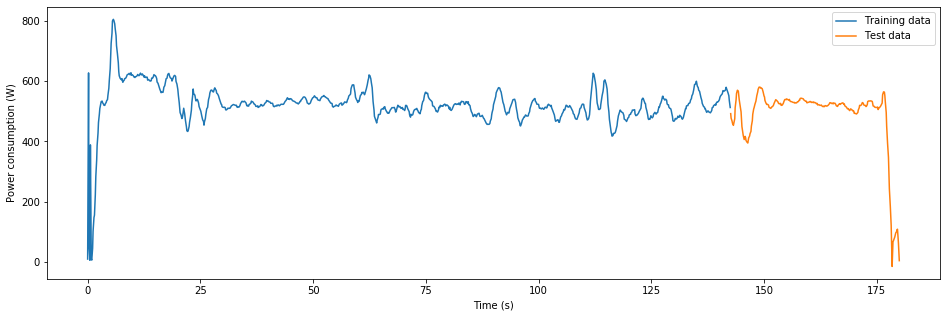

In [18]:
plt.figure(figsize=(16, 5))
plt.plot(X_train["time"], y_train)
plt.plot(X_test["time"], y_test)
plt.ylabel("Power consumption (W)")
plt.xlabel("Time (s)")
plt.legend(["Training data", "Test data"])
plt.show()

## 2. Optimize the base estimator

Before estimating the prediction intervals with MAPIE, let's optimize the
base model, here a :class:`~RandomForestRegressor` through a
:class:`~RandomizedSearchCV` with a temporal cross-validation strategy.
For the sake of computational time, the best parameters are already tuned.



In [20]:
model_params_fit_not_done = True

if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train.values.ravel())
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59
    )

In [21]:
model

RandomForestRegressor(max_depth=13, n_estimators=61, random_state=59)

## 3. Estimate prediction intervals on the test set

We now use :class:`~MapieTimeSeriesRegressor` to build prediction intervals
associated with one-step ahead forecasts. As explained in the introduction,
we use the EnbPI method [1].

Estimating prediction intervals can be possible in two ways:

- with a regular ``.fit`` and ``.predict`` process, limiting the use of
  trainining set residuals to build prediction intervals

- using ``.partial_fit`` in addition to ``.fit`` and ``.predict`` allowing
  MAPIE to use new residuals from the test points as new data are becoming
  available.

The latter method is particularly useful to adjust prediction intervals to
sudden change points on test sets that have not been seen by the model
during training.

Following [1], we use the :class:`~BlockBootstrap` sampling
method instead of the traditional bootstrap strategy for training the model
since the former is more suited for time series data.
Here, we choose to perform 10 resamplings with 10 blocks.



In [22]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### Regular fit
Let's start by estimating prediction intervals without partial fit.



In [23]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train.values.ravel())
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

### Partial fit

Let's now estimate prediction intervals with partial fit. As discussed
previously, the update of the residuals and the one-step ahead predictions
are performed sequentially in a loop.



In [24]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train.values.ravel())

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

## 4. Plot estimated prediction intervals on one-step ahead forecast

Let's now compare the prediction intervals estimated by MAPIE with and
without update of the residuals.



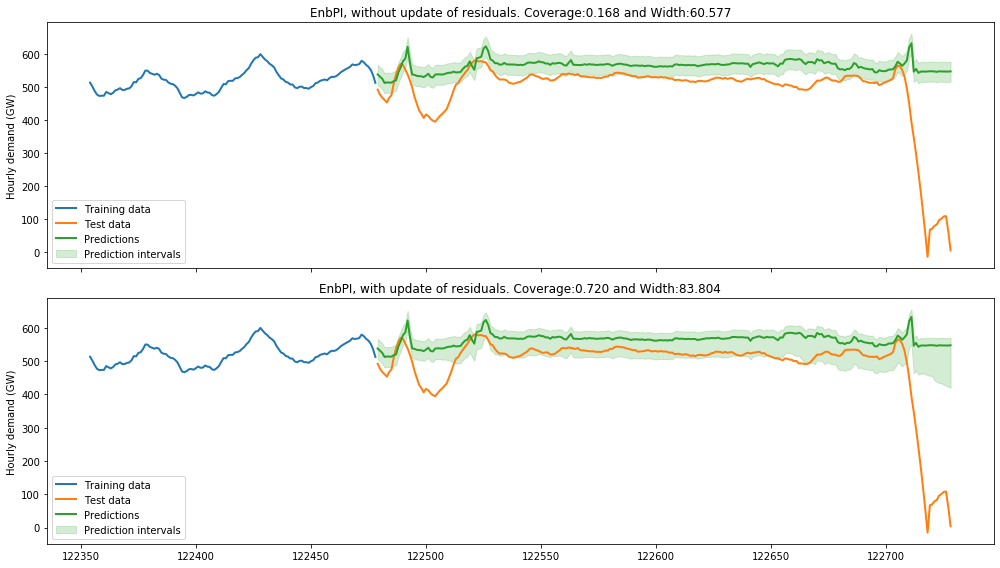

In [25]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

Let's now compare the coverages obtained by MAPIE with and without update
of the residuals on a 24-hour rolling window of prediction intervals.



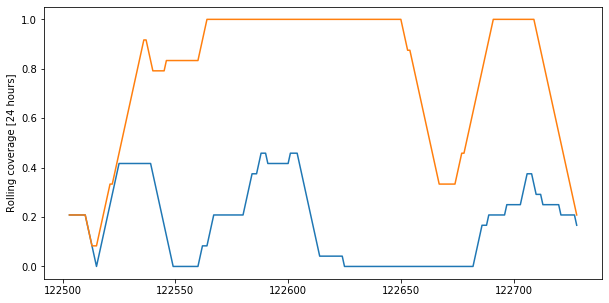

In [26]:
window = 24
rolling_coverage_pfit, rolling_coverage_npfit = [], []
for i in range(window, len(y_test), 1):
    rolling_coverage_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_pfit[i-window:i, 0, 0],
            y_pis_pfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_npfit[i-window:i, 0, 0],
            y_pis_npfit[i-window:i, 1, 0]
        )
    )

plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")
plt.plot(
    y_test[window:].index,
    rolling_coverage_npfit,
    label="Without update of residuals"
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_pfit,
    label="With update of residuals"
)
plt.show()

The training data do not contain a change point, hence the base model cannot
anticipate it.
Without update of the residuals, the prediction intervals are built upon the
distribution of the residuals of the training set.
Therefore they do not cover the true observations after the change point,
leading to a sudden decrease of the coverage.
However, the partial update of the residuals allows the method to capture the
increase of uncertainties of the model predictions.
One can notice that the uncertainty's explosion happens about one day late.
This is because enough new residuals are needed to change the quantiles
obtained from the residuals distribution.

